## Imports

In [ ]:
import os
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import h5py
import numpy as np
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
from datetime import datetime

# Configuration for reproducibility and logging
pl.seed_everything(42)
EXPERIMENT_NAME = f"pathfinder_transformer_{datetime.now().strftime('%Y%m%d_%H%M')}"

## Creating Datasets

In [ ]:
class PathfinderDataset(Dataset):
    def __init__(self, h5_file, difficulty):
        """Initialize dataset with proper access to HDF5 file structure.
        
        Args:
            h5_file: Path to the H5 file containing the pathfinder dataset
            difficulty: String indicating the difficulty level ('easy', 'medium', 'hard')
        """
        self.h5_file = h5py.File(h5_file, "r")
        print(f"\nAvailable keys in {difficulty} dataset:", list(self.h5_file.keys()))
        
        # Directly access the correct keys we now know exist
        self.images = self.h5_file["images"]
        self.labels = self.h5_file["labels"]
        self.difficulty = difficulty
        
        # Log information about our dataset
        self.log_dataset_info()
    
    def log_dataset_info(self):
        """Print comprehensive information about the dataset structure and contents."""
        total_samples = len(self.labels)
        
        # We need to load all labels to compute statistics
        # Using [:] loads the entire dataset into memory
        labels_array = self.labels[:]
        pos_samples = np.sum(labels_array == 1)
        neg_samples = np.sum(labels_array == 0)
        
        print(f"\nDataset Information ({self.difficulty}):")
        print(f"Total samples: {total_samples}")
        print(f"Positive samples (connected): {pos_samples} ({pos_samples/total_samples*100:.2f}%)")
        print(f"Negative samples (not connected): {neg_samples} ({neg_samples/total_samples*100:.2f}%)")
        print(f"Image shape: {self.images[0].shape}")
        
        # Additional helpful information
        print(f"Data type: {self.images.dtype}")
        print(f"Value range: [{np.min(self.images[0])}, {np.max(self.images[0])}]")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """Get a single sample from the dataset with proper preprocessing.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            tuple: (preprocessed_image, label) where image is normalized and properly shaped
        """
        # Load image and convert to float32
        image = self.images[idx].astype(np.float32)
        
        # Reshape to sequence and add channel dimension
        sequence = image.reshape(-1)
        sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)
        
        # Get corresponding label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return sequence, label

## Optimized Transformer Model

In [ ]:
class PathfinderTransformer(pl.LightningModule):
    def __init__(self, 
                 sequence_length=1024,
                 num_classes=2,
                 d_model=128,          # Reduced for faster training
                 nhead=4,              # Reduced for faster training
                 num_layers=3,         # Reduced for faster training
                 dim_feedforward=512,  # Reduced for faster training
                 dropout=0.1,
                 learning_rate=3e-4):
        super().__init__()
        self.save_hyperparameters()
        
        # Model components (same as before but with new parameters)
        self.embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.GELU()
        )
        
        # Positional encoding
        self.register_buffer(
            "pos_encoding",
            self._create_positional_encoding(sequence_length, d_model)
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, num_classes)
        )
        
        # Metrics for each difficulty level
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        
        self.learning_rate = learning_rate
        
        # Keep track of predictions for analysis
        self.test_predictions = []
        self.test_labels = []

    def _create_positional_encoding(self, sequence_length, d_model):
        """Create sinusoidal positional encodings."""
        pos = torch.arange(sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, sequence_length, d_model)
        pe[0, :, 0::2] = torch.sin(pos * div_term)
        pe[0, :, 1::2] = torch.cos(pos * div_term)
        return pe

    def forward(self, x):
        # Create embeddings
        x = self.embedding(x)
        
        # Add positional encoding
        x = x + self.pos_encoding
        
        # Apply transformer
        x = self.transformer(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        logits = self(sequences)
        loss = F.cross_entropy(logits, labels)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, labels)
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        logits = self(sequences)
        loss = F.cross_entropy(logits, labels)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, labels)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.01
        )
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=100,  # Maximum number of epochs
            eta_min=1e-6  # Minimum learning rate
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

    def test_step(self, batch, batch_idx):
        sequences, labels = batch
        logits = self(sequences)
        loss = F.cross_entropy(logits, labels)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = self.test_accuracy(preds, labels)
        
        # Store predictions and labels for analysis
        self.test_predictions.extend(preds.cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

## Data Module to Handle all Datasets

In [ ]:
class PathfinderDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.difficulties = ['easy', 'medium', 'hard']
        
    def setup(self, stage=None):
        for difficulty in self.difficulties:
            file_path = os.path.join(self.data_dir, f'merged_data_{difficulty}.h5')
            dataset = PathfinderDataset(file_path, difficulty)
            
            # Split dataset
            total_size = len(dataset)
            train_size = int(0.7 * total_size)
            val_size = int(0.15 * total_size)
            test_size = total_size - train_size - val_size
            
            splits = torch.utils.data.random_split(
                dataset, 
                [train_size, val_size, test_size]
            )
            
            setattr(self, f'{difficulty}_train', splits[0])
            setattr(self, f'{difficulty}_val', splits[1])
            setattr(self, f'{difficulty}_test', splits[2])
    
    def train_dataloader(self, difficulty='easy'):
        return DataLoader(
            getattr(self, f'{difficulty}_train'),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
    
    def val_dataloader(self, difficulty='easy'):
        return DataLoader(
            getattr(self, f'{difficulty}_val'),
            batch_size=self.batch_size,
            num_workers=4,
            pin_memory=True
        )
    
    def test_dataloader(self, difficulty='easy'):
        return DataLoader(
            getattr(self, f'{difficulty}_test'),
            batch_size=self.batch_size,
            num_workers=4,
            pin_memory=True
        )

## Training Function

In [ ]:
def train_and_evaluate(data_module, difficulty):
    """Train and evaluate model for a specific difficulty level."""
    
    # Create model
    model = PathfinderTransformer()
    
    # Create callbacks
    callbacks = [
        ModelCheckpoint(
            dirpath=f'checkpoints/{difficulty}',
            filename=f'{difficulty}-{{epoch}}-{{val_acc:.2f}}',
            monitor='val_acc',
            mode='max',
            save_top_k=3
        ),
        EarlyStopping(
            monitor='val_acc',
            mode='max',
            patience=10,
            verbose=True
        ),
        LearningRateMonitor(logging_interval='step')
    ]
    
    # Create logger
    logger = TensorBoardLogger(
        save_dir='logs',
        name=f'{EXPERIMENT_NAME}/{difficulty}'
    )
    
    # Create trainer with single GPU configuration
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator='gpu',
        devices=1,  # Using single GPU
        precision='16-mixed',  # Using mixed precision for faster training
        callbacks=callbacks,
        logger=True,
        gradient_clip_val=1.0,
        log_every_n_steps=10,
        enable_progress_bar=True
    )
    
    # Train model
    print(f"\nTraining on {difficulty} dataset:")
    trainer.fit(
        model,
        train_dataloaders=data_module.train_dataloader(difficulty),
        val_dataloaders=data_module.val_dataloader(difficulty)
    )
    
    # Test model
    print(f"\nTesting on {difficulty} dataset:")
    trainer.test(
        model,
        dataloaders=data_module.test_dataloader(difficulty)
    )
    
    return model, trainer

# Main execution
def run_all_experiments():
    data_module = PathfinderDataModule('/kaggle/input/pathfinder-data')
    data_module.setup()
    
    results = {}
    for difficulty in ['easy', 'medium', 'hard']:
        print(f"\n{'='*50}")
        print(f"Starting experiments for {difficulty} difficulty")
        print(f"{'='*50}")
        
        model, trainer = train_and_evaluate(data_module, difficulty)
        results[difficulty] = {
            'test_acc': trainer.callback_metrics.get('test_acc').item(),
            'test_loss': trainer.callback_metrics.get('test_loss').item()
        }
    
    # Print final results
    print("\nFinal Results:")
    print("="*50)
    for difficulty, metrics in results.items():
        print(f"\n{difficulty.upper()} Dataset:")
        print(f"Test Accuracy: {metrics['test_acc']*100:.2f}%")
        print(f"Test Loss: {metrics['test_loss']:.4f}")

# Run all experiments
run_all_experiments()

## Data Analysis


Dataset Structure for EASY difficulty:

Available keys: ['images', 'labels']

Dataset Information:
Total samples: 199800
Image shape: (32, 32)
Data type: uint8
Value range: [0, 255]

Class Distribution:
Positive samples (connected): 99985 (50.04%)
Negative samples (not connected): 99815 (49.96%)

Pixel Statistics:
Mean pixel value: 11.79
Std pixel value: 40.16
Median pixel value: 0.00


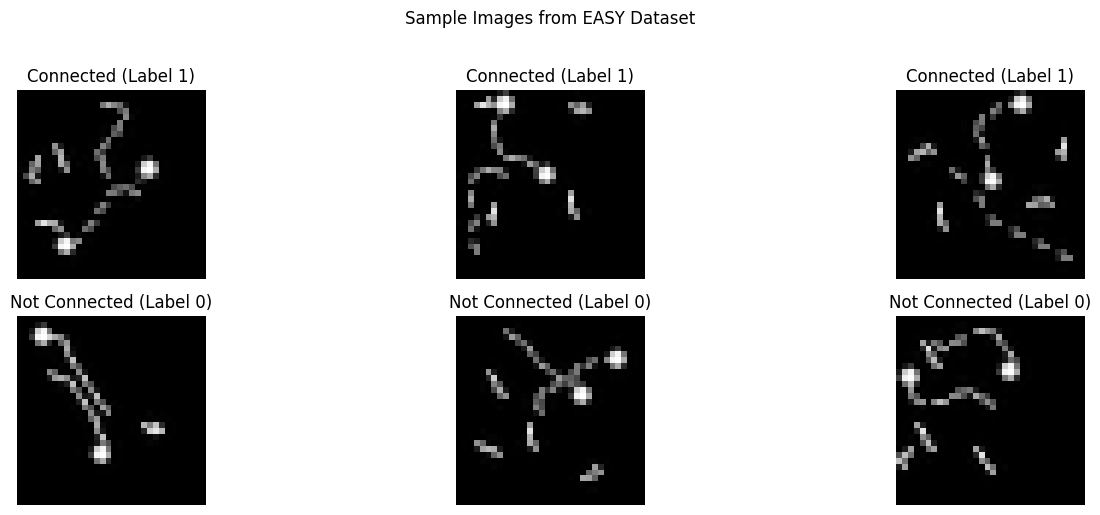

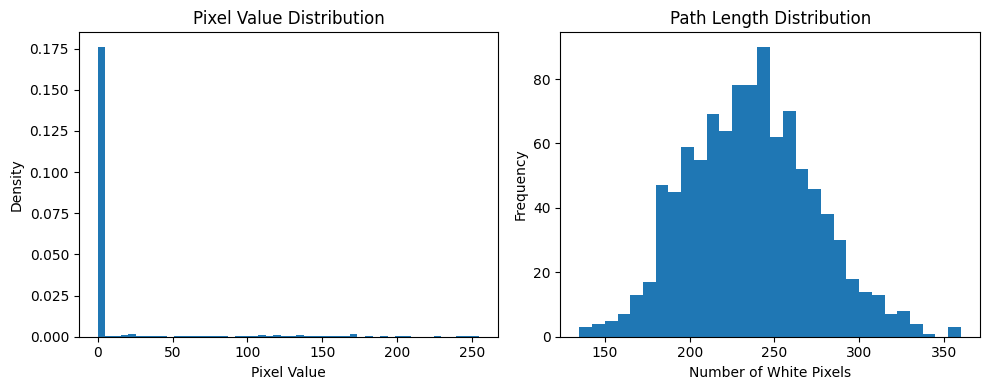


Dataset Structure for MEDIUM difficulty:

Available keys: ['images', 'labels']

Dataset Information:
Total samples: 200000
Image shape: (32, 32)
Data type: uint8
Value range: [0, 255]

Class Distribution:
Positive samples (connected): 100222 (50.11%)
Negative samples (not connected): 99778 (49.89%)

Pixel Statistics:
Mean pixel value: 15.55
Std pixel value: 44.50
Median pixel value: 0.00


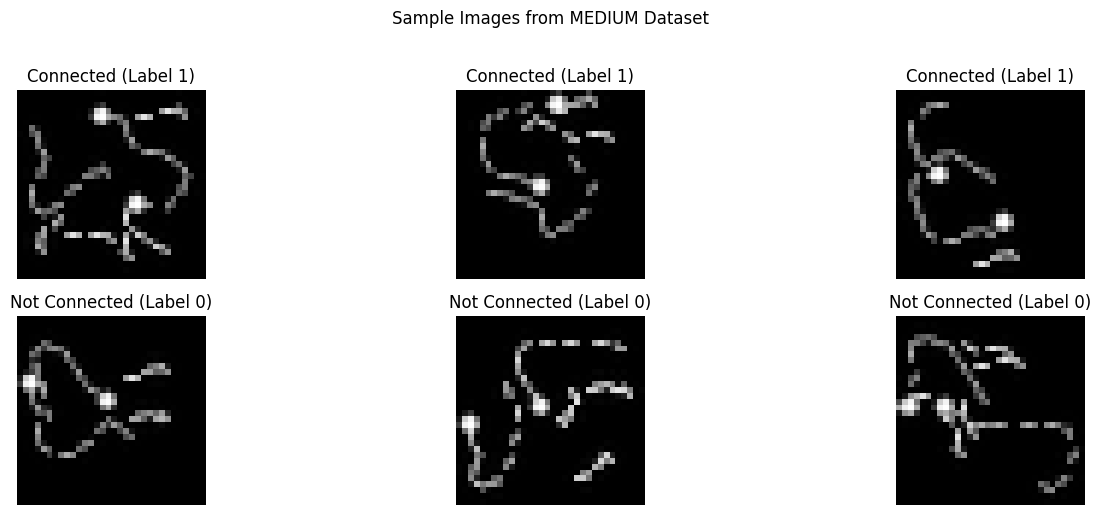

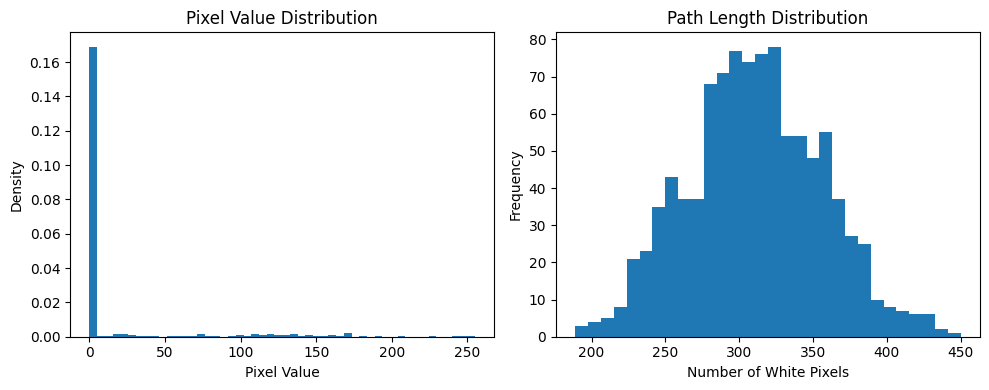


Dataset Structure for HARD difficulty:

Available keys: ['images', 'labels']

Dataset Information:
Total samples: 200000
Image shape: (32, 32)
Data type: uint8
Value range: [0, 255]

Class Distribution:
Positive samples (connected): 99920 (49.96%)
Negative samples (not connected): 100080 (50.04%)

Pixel Statistics:
Mean pixel value: 19.95
Std pixel value: 48.66
Median pixel value: 0.00


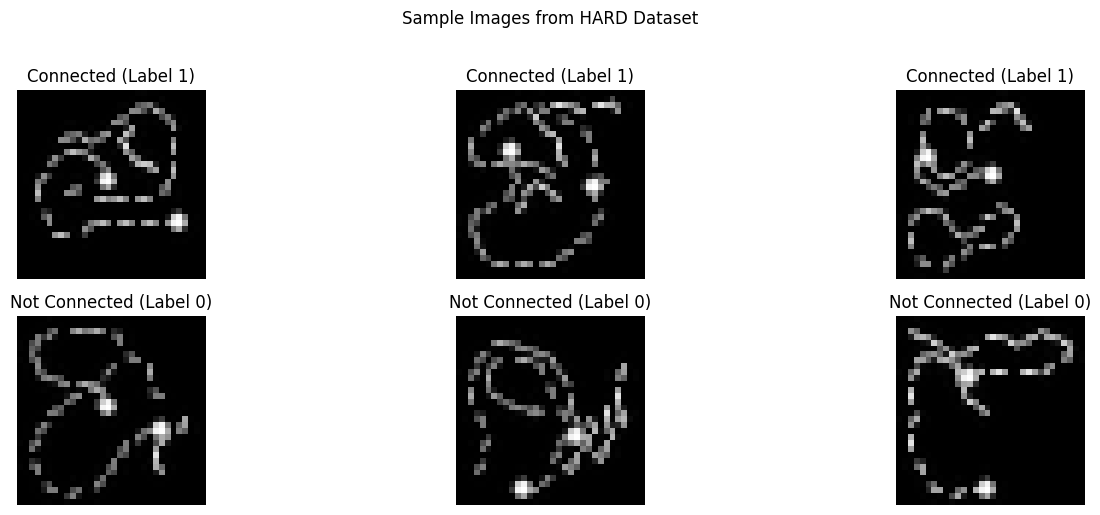

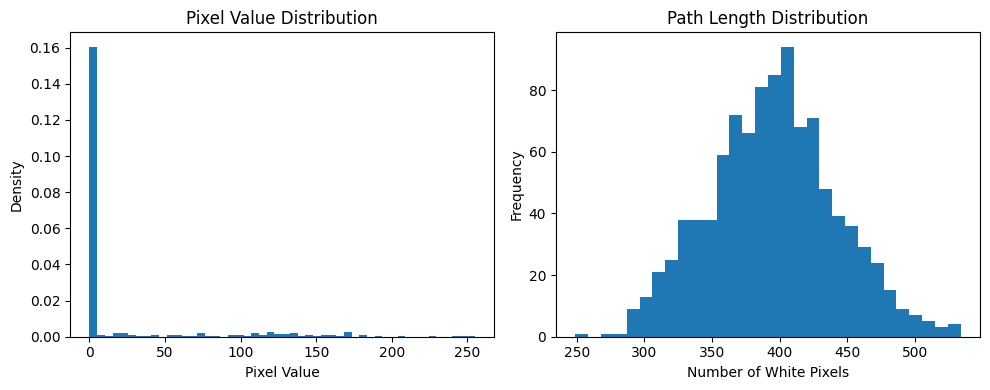

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def explore_pathfinder_dataset(difficulty):
    """
    Comprehensive exploration of a Pathfinder dataset.
    
    Args:
        difficulty: String indicating which dataset to analyze ('easy', 'medium', 'hard')
    """
    file_path = f'/kaggle/input/pathfinder-data/merged_data_{difficulty}.h5'
    
    with h5py.File(file_path, 'r') as f:
        # Display dataset structure
        print(f"\n{'='*50}")
        print(f"Dataset Structure for {difficulty.upper()} difficulty:")
        print(f"{'='*50}")
        print("\nAvailable keys:", list(f.keys()))
        
        # Load data
        images = f['images'][:]
        labels = f['labels'][:]
        
        # Basic dataset information
        print("\nDataset Information:")
        print(f"Total samples: {len(images)}")
        print(f"Image shape: {images[0].shape}")
        print(f"Data type: {images.dtype}")
        print(f"Value range: [{images.min()}, {images.max()}]")
        
        # Class distribution
        pos_samples = np.sum(labels == 1)
        neg_samples = np.sum(labels == 0)
        print(f"\nClass Distribution:")
        print(f"Positive samples (connected): {pos_samples} ({pos_samples/len(labels)*100:.2f}%)")
        print(f"Negative samples (not connected): {neg_samples} ({neg_samples/len(labels)*100:.2f}%)")
        
        # Statistical analysis
        print("\nPixel Statistics:")
        print(f"Mean pixel value: {images.mean():.2f}")
        print(f"Std pixel value: {images.std():.2f}")
        print(f"Median pixel value: {np.median(images):.2f}")
        
        # Visualize sample images
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Sample Images from {difficulty.upper()} Dataset', y=1.02)
        
        # Plot connected examples
        for i in range(3):
            idx = np.where(labels == 1)[0][i]
            plt.subplot(2, 3, i+1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(f'Connected (Label 1)')
            plt.axis('off')
        
        # Plot non-connected examples
        for i in range(3):
            idx = np.where(labels == 0)[0][i]
            plt.subplot(2, 3, i+4)
            plt.imshow(images[idx], cmap='gray')
            plt.title(f'Not Connected (Label 0)')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Analyze pixel distribution
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(images.ravel(), bins=50, density=True)
        plt.title('Pixel Value Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Density')
        
        # Show distribution of path lengths (white pixels)
        path_lengths = [(img > 0).sum() for img in images[:1000]]  # Sample first 1000 images
        plt.subplot(1, 2, 2)
        plt.hist(path_lengths, bins=30)
        plt.title('Path Length Distribution')
        plt.xlabel('Number of White Pixels')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Analyze all difficulty levels
for difficulty in ['easy', 'medium', 'hard']:
    explore_pathfinder_dataset(difficulty)